## Q1 (b)

In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

/home/ziruiqiu/anaconda3/envs/DL2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/ziruiqiu/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/ziruiqiu/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:23<00:00, 10.3MB/s]   


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(file_path):
    img = Image.open(file_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Top prediction:  218: 'Welsh springer spaniel',


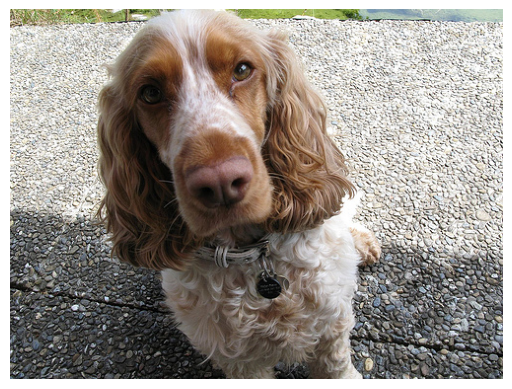

Top prediction:  107: 'jellyfish',


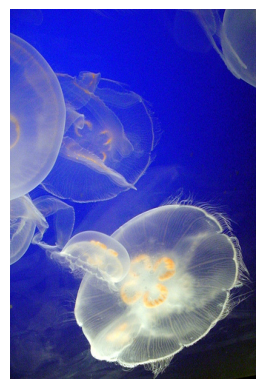

Top prediction:  31: 'tree frog, tree-frog',


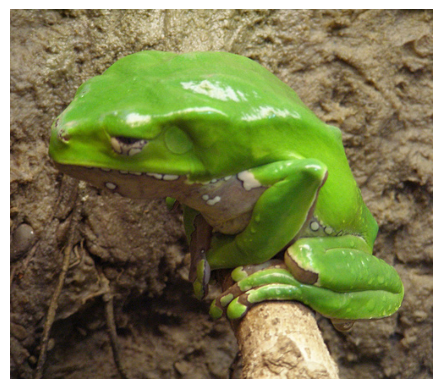

In [100]:
import torchvision.models as models
import torchvision.transforms as transforms



# Define transformation for input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

# Load class labels
with open('imagenet1000_clsidx_to_labels.txt') as f:
    class_labels = [line.strip() for line in f.readlines()]

def predict(image_path):
    # Load input image
    image = Image.open(image_path).convert('RGB')

    # Apply transformation to input image
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)
    #print(input_tensor.shape)
    # Make prediction on input image
    with torch.no_grad():
        output = model(input_batch)

    # Get index of top prediction
    _, index = torch.max(output, 1)

    # Get class label for top prediction
    label = class_labels[index]

    # Print top prediction label
    print("Top prediction: ", label)

predict('dog.jpg')
display_image('dog.jpg')
predict('jellyfish.jpg')
display_image('jellyfish.jpg')
predict('frog.jpg')
display_image('frog.jpg')



## Q1 (c)

In [101]:
import numpy as np
def generate_adversarial_example(model, image_path, target_classes, alpha=0.00001, num_steps=1000):
    # Load input image
    image = Image.open(image_path).convert('RGB')

    # Apply transformation to input image
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)

    # Get predicted class label for input image
    with torch.no_grad():
        output = model(input_batch)
    _, index = torch.max(output, 1)
    true_class = index.item()

    # Select target class to optimize for
    target_class = target_classes[np.random.randint(0, len(target_classes))]

    # Define optimizer and loss function
    optimizer = torch.optim.Adam([input_batch.requires_grad_()], lr=0.01)
    loss_fn = torch.nn.CrossEntropyLoss()
    # Run optimization
    for i in range(num_steps):
        # Compute loss
        output = model(input_batch)
        loss = alpha * torch.norm(input_batch.view(-1), p=1) + loss_fn(output, torch.tensor([target_class]))
        #print(torch.norm(input_batch.view(-1), p=1))
        # Update input tensor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Check if target class has been reached
        _, index = torch.max(output, 1)
        predicted_class = index.item()
        if predicted_class == target_class:
            break

    # Get predicted class label for adversarial example
    with torch.no_grad():
        output = model(input_batch)
    _, index = torch.max(output, 1)
    adversarial_class = index.item()
    # Print true class, target class, and adversarial class
    print("True class: ", class_labels[true_class])
    print("Target class: ", class_labels[target_class])
    print("Adversarial class: ", class_labels[adversarial_class])

    # Convert input tensor back to PIL image
    #adversarial_image = transforms.ToPILImage()(input_batch.squeeze())

    return input_batch, class_labels[adversarial_class] 

True class:  218: 'Welsh springer spaniel',
Target class:  {0: 'tench, Tinca tinca',
Adversarial class:  {0: 'tench, Tinca tinca',


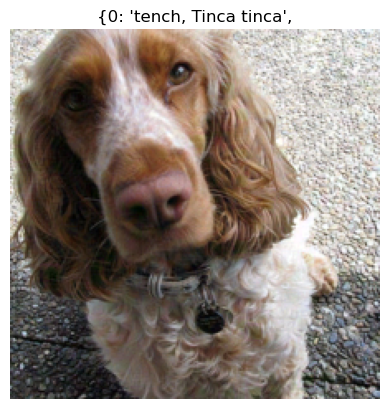

True class:  218: 'Welsh springer spaniel',
Target class:  1: 'goldfish, Carassius auratus',
Adversarial class:  1: 'goldfish, Carassius auratus',


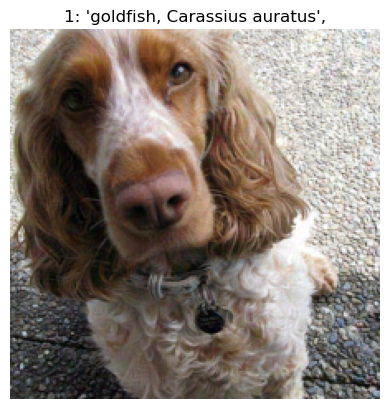

True class:  218: 'Welsh springer spaniel',
Target class:  2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
Adversarial class:  2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',


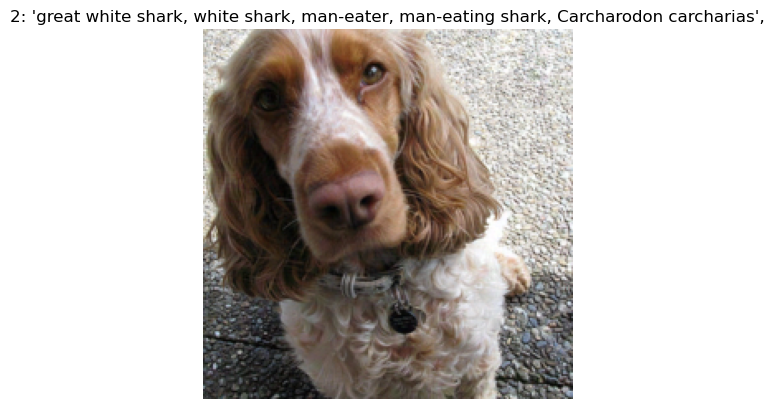

In [102]:
for i in range(3):
    adversarial_image, adversarial_class = generate_adversarial_example(model, 'dog.jpg', [i])
    adversarial_image = denormalize((adversarial_image)).clamp(0, 1)
    # Convert input tensor back to PIL image
    adversarial_image = transforms.ToPILImage()(adversarial_image.squeeze(0))
    plt.imshow(adversarial_image)
    plt.title(adversarial_class)
    plt.axis('off')
    plt.show()

True class:  107: 'jellyfish',
Target class:  3: 'tiger shark, Galeocerdo cuvieri',
Adversarial class:  3: 'tiger shark, Galeocerdo cuvieri',


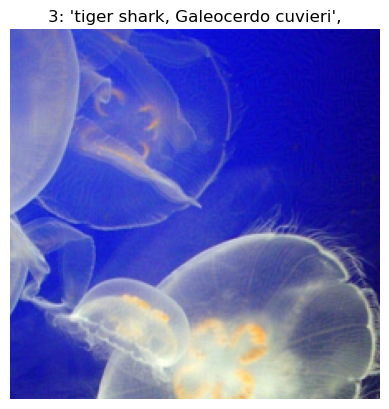

True class:  107: 'jellyfish',
Target class:  4: 'hammerhead, hammerhead shark',
Adversarial class:  4: 'hammerhead, hammerhead shark',


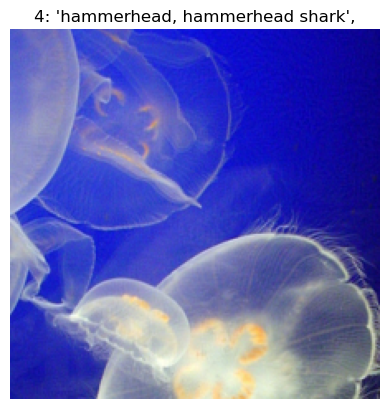

True class:  107: 'jellyfish',
Target class:  5: 'electric ray, crampfish, numbfish, torpedo',
Adversarial class:  5: 'electric ray, crampfish, numbfish, torpedo',


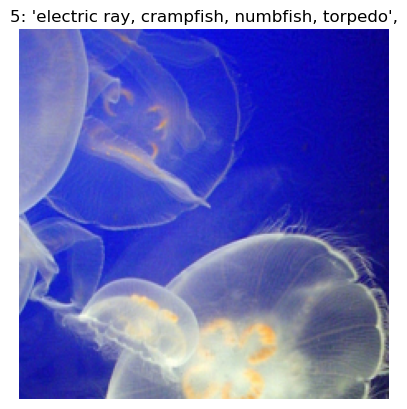

In [103]:
for i in range(3, 6):
    adversarial_image, adversarial_class = generate_adversarial_example(model, 'jellyfish.jpg', [i])
    adversarial_image = denormalize((adversarial_image)).clamp(0, 1)
    # Convert input tensor back to PIL image
    adversarial_image = transforms.ToPILImage()(adversarial_image.squeeze(0))
    plt.imshow(adversarial_image)
    plt.title(adversarial_class)
    plt.axis('off')
    plt.show()